In [1]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import equinox as eqx
import diffrax
import optax
from functools import partial

In [2]:
import os
os.chdir("..")
from policy.policy_training import DPCTrainer
from exciting_environments.pmsm.pmsm_env import PMSM, step_eps
import jax_dataclasses as jdc
from models.models import NeuralEulerODE,MLP
#from policy.networks import MLP#,MLP2
import matplotlib.pyplot as plt

2025-03-04 16:44:03.772344: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[1])
jax.config.update("jax_enable_x64", False)

In [4]:
class ExpertModel(eqx.Module):
    motor_env: PMSM = eqx.field(static=True)
    psi_dq_mlp: MLP

    def __init__(self, motor_env, psi_layer_sizes, key):
        self.motor_env = motor_env
        key, subkey = jax.random.split(key)
        self.psi_dq_mlp = MLP(
            psi_layer_sizes, key=subkey, hidden_activation=jax.nn.swish, output_activation=jax.nn.tanh
        )

    def __call__(self, init_obs, actions, tau):

        def body_fun(carry, action):
            obs = carry
            obs = self.step(obs, action, tau)
            return obs, obs

        _, observations = jax.lax.scan(body_fun, init_obs, actions)
        observations = jnp.concatenate([init_obs[None, :], observations], axis=0)
        return observations

    def step(self, obs, action, tau):
        obs1, _ = self.motor_env.reset(self.motor_env.env_properties)  #
        obs1 = obs1.at[2].set((3 * 1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
        obs1 = obs1.at[0].set(obs[0])
        obs1 = obs1.at[1].set(obs[1])
        obs1 = obs1.at[4].set(obs[2])
        obs1 = obs1.at[5].set(obs[3])
        state = self.motor_env.generate_state_from_observation(obs1, self.motor_env.env_properties)
        # obs,_= self.motor_env.step(state, action, self.motor_env.env_properties)
        obs, _ = self.step_expert(state, action, self.motor_env.env_properties)
        return jnp.concatenate([obs[0:2], obs[4:6]])

    #@partial(jax.jit, static_argnums=[0, 3])
    def ode_step(self, state, u_dq, properties):
        """Computes state by simulating one step.

        Args:
            system_state: The state from which to calculate state for the next step.
            u_dq: The action to apply to the environment.
            properties: Parameters and settings of the environment, that do not change over time.

        Returns:
            state: The computed state after the one step simulation.
        """
        system_state = state.physical_state
        omega_el = system_state.omega_el
        i_d = system_state.i_d
        i_q = system_state.i_q
        eps = system_state.epsilon

        args = (u_dq, properties.static_params)
        if properties.saturated:

            def vector_field(t, y, args):
                i_d, i_q = y
                u_dq, _ = args

                J_k = jnp.array([[0, -1], [1, 0]])
                i_dq = jnp.array([i_d, i_q])
                p_d = {q: interp(jnp.array([i_d, i_q])) for q, interp in self.motor_env.LUT_interpolators.items()}
                i_dq_norm = i_dq / properties.physical_constraints.i_d

                p_d["Psi_d"] = self.Psi_d(i_dq_norm)
                p_d["Psi_q"] = self.Psi_q(i_dq_norm)
                p_d["L_dd"] = self.L_dd(i_dq_norm)
                p_d["L_dq"] = self.L_dq(i_dq_norm)
                p_d["L_qd"] = self.L_qd(i_dq_norm)
                p_d["L_qq"] = self.L_qq(i_dq_norm)

                L_diff = jnp.column_stack([p_d[q] for q in ["L_dd", "L_dq", "L_qd", "L_qq"]]).reshape(2, 2)
                L_diff_inv = jnp.linalg.inv(L_diff)
                psi_dq = jnp.column_stack([p_d[psi] for psi in ["Psi_d", "Psi_q"]]).reshape(-1)
                di_dq_1 = jnp.einsum(
                    "ij,j->i",
                    (-L_diff_inv * properties.static_params.r_s),
                    i_dq,
                )
                di_dq_2 = jnp.einsum("ik,k->i", L_diff_inv, u_dq)
                di_dq_3 = jnp.einsum("ij,jk,k->i", -L_diff_inv, J_k, psi_dq) * omega_el
                i_dq_diff = di_dq_1 + di_dq_2 + di_dq_3
                d_y = i_dq_diff[0], i_dq_diff[1]

                return d_y

        else:

            def vector_field(t, y, args):
                i_d, i_q = y
                u_dq, params = args
                u_d = u_dq[0]
                u_q = u_dq[1]
                l_d = params.l_d
                l_q = params.l_q
                psi_p = params.psi_p
                r_s = params.r_s
                i_d_diff = (u_d + omega_el * l_q * i_q - r_s * i_d) / l_d
                i_q_diff = (u_q - omega_el * (l_d * i_d + psi_p) - r_s * i_q) / l_q
                d_y = i_d_diff, i_q_diff
                return d_y

        term = diffrax.ODETerm(vector_field)
        t0 = 0
        t1 = self.motor_env.tau
        y0 = tuple([i_d, i_q])
        env_state = self.motor_env._solver.init(term, t0, t1, y0, args)
        y, _, _, env_state, _ = self.motor_env._solver.step(term, t0, t1, y0, args, env_state, made_jump=False)

        i_d_k1 = y[0]
        i_q_k1 = y[1]

        if properties.saturated:
            torque = jnp.array(
                [self.motor_env.currents_to_torque_saturated(i_d=i_d_k1, i_q=i_q_k1, env_properties=properties)]
            )[0]
        else:
            torque = jnp.array([self.motor_env.currents_to_torque(i_d_k1, i_q_k1, properties)])[0]

        with jdc.copy_and_mutate(system_state, validate=False) as system_state_next:
            system_state_next.epsilon = step_eps(eps, omega_el, self.motor_env.tau, 1.0)
            system_state_next.i_d = i_d_k1
            system_state_next.i_q = i_q_k1
            system_state_next.torque = torque  # [0]

        with jdc.copy_and_mutate(state, validate=False) as state_next:
            state_next.physical_state = system_state_next
        return state_next

    #@partial(jax.jit, static_argnums=[0, 3])
    def step_expert(self, state, action, env_properties):
        """Computes state by simulating one step taking the deadtime into account.

        Args:
            system_state: The state from which to calculate state for the next step.
            action: The action to apply to the environment.
            properties: Parameters and settings of the environment, that do not change over time.

        Returns:
            state: The computed state after the one step simulation.
        """

        action = self.motor_env.constraint_denormalization(action, state, env_properties)

        action_buffer = jnp.array([state.physical_state.u_d_buffer, state.physical_state.u_q_buffer])

        if env_properties.static_params.deadtime > 0:

            updated_buffer = jnp.array([action[0], action[1]])
            u_dq = action_buffer
        else:
            updated_buffer = action_buffer

            u_dq = action

        next_state = self.ode_step(state, u_dq, env_properties)
        with jdc.copy_and_mutate(next_state, validate=True) as next_state_update:
            next_state_update.physical_state.u_d_buffer = updated_buffer[0]
            next_state_update.physical_state.u_q_buffer = updated_buffer[1]

        observation = self.motor_env.generate_observation(next_state_update, env_properties)
        return observation, next_state_update

    def Psi_d(self, i_dq_norm):
        return self.psi_dq_mlp(i_dq_norm)[0]  #  self.motor_env.LUT_interpolators["Psi_d"](i_dq)[0]

    def Psi_q(self, i_dq_norm):
        return self.psi_dq_mlp(i_dq_norm)[1]  #   self.motor_env.LUT_interpolators["Psi_q"](i_dq)[0]

    def Psi_d_physical(self, i_dq):
        i_dq_norm = i_dq / self.motor_env.env_properties.physical_constraints.i_d
        return self.Psi_d(i_dq_norm)

    def Psi_q_physical(self, i_dq):
        i_dq_norm = i_dq / self.motor_env.env_properties.physical_constraints.i_d
        return self.Psi_q(i_dq_norm)

    def l_d_dq(self, i_dq):
        return jax.grad(self.Psi_d_physical)(i_dq)

    def l_q_dq(self, i_dq):
        return jax.grad(self.Psi_q_physical)(i_dq)

    def L_dd(self, i_dq_norm):
        i_dq = i_dq_norm * self.motor_env.env_properties.physical_constraints.i_d
        return self.l_d_dq(i_dq)[0]

    def L_dq(self, i_dq_norm):
        i_dq = i_dq_norm * self.motor_env.env_properties.physical_constraints.i_d
        return self.l_d_dq(i_dq)[1]

    def L_qd(self, i_dq_norm):
        i_dq = i_dq_norm * self.motor_env.env_properties.physical_constraints.i_d
        return self.l_q_dq(i_dq)[0]

    def L_qq(self, i_dq_norm):
        i_dq = i_dq_norm * self.motor_env.env_properties.physical_constraints.i_d
        return self.l_q_dq(i_dq)[1]

    def L_matrix(self, i_dq):
        L_dd = self.L_dd(i_dq)
        L_dq = self.L_dq(i_dq)
        L_qd = self.L_qd(i_dq)
        L_qq = self.L_qq(i_dq)
        mat = jnp.array([[L_dd, L_dq], [L_qd, L_qq]])
        return mat


In [5]:
motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[], 
    static_params = {
            "p": 3,
            "r_s": 15e-3,
            "l_d": 0.37e-3,
            "l_q": 1.2e-3,
            "psi_p": 65.6e-3,
            "deadtime": 0,
    })

In [6]:
import json
with open("model_data/dmpe1.json") as json_data:
    d = json.load(json_data)
long_obs = jnp.array(d["observations"])
long_acts = jnp.array(d["actions"])
def step_eps(eps, omega_el, tau, tau_scale=1.0):
    eps += omega_el * tau * tau_scale
    eps %= 2 * jnp.pi
    boolean = eps > jnp.pi
    summation_mask = boolean * -2 * jnp.pi
    eps = eps + summation_mask
    return eps
eps = [0]
for i in range(long_obs.shape[0]):
    eps.append(step_eps(eps[-1], 3 * 1500 / 60 * 2 * jnp.pi, 1e-4))
cos_long_eps = jnp.cos(jnp.array(eps[:-1])[:, None])
sin_long_eps = jnp.sin(jnp.array(eps[:-1])[:, None])
long_obs = jnp.hstack([long_obs, cos_long_eps, sin_long_eps])


In [7]:
class BlackWrapperEps(eqx.Module):
    node: eqx.Module
    def __init__(self, node):
        self.node = node

    def __call__(self, init_obs, actions, tau):
        init_obs=init_obs[:2]
        return self.node(init_obs, actions, tau)

    def step(self, obs, action, tau):
        obs1 = obs[:2]
        return self.node.step(obs1, action, tau)

In [8]:
class GtWrapper(eqx.Module):
    motor_env: PMSM = eqx.field(static=True)
    def __init__(self, motor_env):
        self.motor_env = motor_env

    def __call__(self, init_obs, actions, tau):

        def body_fun(carry, action):
            obs = carry
            obs = self.step(obs, action, tau)
            return obs, obs

        _, observations = jax.lax.scan(body_fun, init_obs, actions)
        observations = jnp.concatenate([init_obs[None, :], observations], axis=0)
        return observations

    def step(self, obs, action, tau):
        obs1, _ = self.motor_env.reset(self.motor_env.env_properties)  #
        obs1 = obs1.at[2].set((3 * 1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
        obs1 = obs1.at[0].set(obs[0])
        obs1 = obs1.at[1].set(obs[1])
        obs1 = obs1.at[4].set(obs[2])
        obs1 = obs1.at[5].set(obs[3])
        state = self.motor_env.generate_state_from_observation(obs1, self.motor_env.env_properties)
        # obs,_= self.motor_env.step(state, action, self.motor_env.env_properties)
        obs, _ = self.motor_env.step(state, action, self.motor_env.env_properties)
        return jnp.concatenate([obs[0:2], obs[4:6]])

In [9]:
long_obs[0,:]

Array([0., 0., 1., 0.], dtype=float32)

In [10]:
long_acts2=jnp.concatenate([long_acts,jnp.array([0,0])[None,:]],axis=0)

In [11]:
long_obs.shape

(50000, 4)

In [42]:
def comp_sim(model,model_gt,tau,sequence_len):
    stacked_obs=long_obs.reshape(-1, sequence_len,4)
    long_acts_helper=jnp.concatenate([long_acts,jnp.array([0,0])[None,:]],axis=0)
    stacked_acts=long_acts_helper.reshape(-1, sequence_len, 2)[:,:-1,:]
    sim = jax.vmap(model.__call__, in_axes=(0, 0,None))(stacked_obs[:,0,:], stacked_acts,tau)
    sim_gt = jax.vmap(model_gt.__call__, in_axes=(0, 0,None))(
            stacked_obs[:,0], stacked_acts, tau
        )
    return jnp.nanmean((sim[:,:,:2] - sim_gt[:,:,:2]) ** 2)

In [13]:
def valid(obs):
    return (obs[:,:,0]**2+obs[:,:,0]**2)<=1
def comp_sim_valid(model,model_gt,tau,sequence_len):
    stacked_obs=long_obs.reshape(-1, sequence_len,4)
    long_acts_helper=jnp.concatenate([long_acts,jnp.array([0,0])[None,:]],axis=0)
    stacked_acts=long_acts_helper.reshape(-1, sequence_len, 2)[:,:-1,:]
    sim = jax.vmap(model.__call__, in_axes=(0, 0,None))(stacked_obs[:,0,:], stacked_acts,tau)
    sim_gt = jax.vmap(model_gt.__call__, in_axes=(0, 0,None))(
            stacked_obs[:,0], stacked_acts, tau
        )
    return jnp.mean((sim[:,:,:2] - sim_gt[:,:,:2])[valid(sim)] ** 2)

In [14]:
gt_wrap=GtWrapper(motor_env=motor_env)

In [15]:
jax_key = jax.random.PRNGKey(14)
node_struct= ExpertModel(motor_env=motor_env,psi_layer_sizes=[2,128,128,128,128,2],key=jax_key)
grey_node = eqx.tree_deserialise_leaves(f"final_models/grey_box/Model_4_128_2.eqx", node_struct) 

In [16]:
jax_key = jax.random.PRNGKey(2)
node_struct=NeuralEulerODE([6,128,128,128,128,4],key=jax_key)
black_node = eqx.tree_deserialise_leaves("final_models/black_box/Model_eps_4_128_9.eqx", node_struct)

In [17]:
jax_key = jax.random.PRNGKey(2)
node_struct=NeuralEulerODE([4,128,128,128,128,2],key=jax_key)
node_no_eps = eqx.tree_deserialise_leaves("final_models/black_box/Model_4_128_7.eqx", node_struct)
black_node_no_eps=BlackWrapperEps(node=node_no_eps)

In [18]:
def mse_metrics_sim(size, seuqence_len):
    values_grey=[]
    values_black=[]
    values_black_no_eps=[]
    for i in range(10):
        jax_key = jax.random.PRNGKey(2)
        node_struct=NeuralEulerODE(([4]+size+[2]),key=jax_key)
        node_no_eps = eqx.tree_deserialise_leaves(f"final_models/black_box/Model_{len(size)}_{size[0]}_{i+1}.eqx", node_struct)
        black_node_no_eps=BlackWrapperEps(node=node_no_eps)
        node_struct=NeuralEulerODE(([6]+size+[4]),key=jax_key)
        black_node = eqx.tree_deserialise_leaves(f"final_models/black_box/Model_eps_{len(size)}_{size[0]}_{i+1}.eqx", node_struct)
        node_struct= ExpertModel(motor_env=motor_env,psi_layer_sizes=([2]+size+[2]),key=jax_key)
        grey_node = eqx.tree_deserialise_leaves(f"final_models/grey_box/Model_{len(size)}_{size[0]}_{i+1}.eqx", node_struct)

        value_grey=comp_sim(grey_node,gt_wrap,1e-4,seuqence_len)
        value_black=comp_sim(black_node,gt_wrap,1e-4,seuqence_len)
        value_black_no_eps=comp_sim(black_node_no_eps,gt_wrap,1e-4,seuqence_len)
        values_grey.append(value_grey)
        values_black.append(value_black)
        values_black_no_eps.append(value_black_no_eps)
    
    return values_grey, values_black, values_black_no_eps

In [19]:
def mse_metrics_sim_valid(size, seuqence_len):
    values_grey=[]
    values_black=[]
    values_black_no_eps=[]
    for i in range(10):
        jax_key = jax.random.PRNGKey(2)
        node_struct=NeuralEulerODE(([4]+size+[2]),key=jax_key)
        node_no_eps = eqx.tree_deserialise_leaves(f"final_models/black_box/Model_{len(size)}_{size[0]}_{i+1}.eqx", node_struct)
        black_node_no_eps=BlackWrapperEps(node=node_no_eps)
        node_struct=NeuralEulerODE(([6]+size+[4]),key=jax_key)
        black_node = eqx.tree_deserialise_leaves(f"final_models/black_box/Model_eps_{len(size)}_{size[0]}_{i+1}.eqx", node_struct)
        node_struct= ExpertModel(motor_env=motor_env,psi_layer_sizes=([2]+size+[2]),key=jax_key)
        grey_node = eqx.tree_deserialise_leaves(f"final_models/grey_box/Model_{len(size)}_{size[0]}_{i+1}.eqx", node_struct)

        value_grey=comp_sim_valid(grey_node,gt_wrap,1e-4,seuqence_len)
        value_black=comp_sim_valid(black_node,gt_wrap,1e-4,seuqence_len)
        value_black_no_eps=comp_sim_valid(black_node_no_eps,gt_wrap,1e-4,seuqence_len)
        values_grey.append(value_grey)
        values_black.append(value_black)
        values_black_no_eps.append(value_black_no_eps)
    
    return values_grey, values_black, values_black_no_eps

## 10 Step simulation

In [20]:
from tabulate import tabulate

In [43]:
mse_grey_10_big,mse_black,mse_black_no_eps_10_big=mse_metrics_sim([128,128,128,128],10)
#print([128,128,128,128])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))
mse_grey_10_mid,mse_black,mse_black_no_eps_10_mid=mse_metrics_sim([64,64,64],10)
#print([64,64,64])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))
mse_grey_10_small,mse_black,mse_black_no_eps_10_small=mse_metrics_sim([32,32],10)
#print([32,32])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))

## 25 Step Simulation

In [44]:
mse_grey_25_big,mse_black,mse_black_no_eps_25_big=mse_metrics_sim([128,128,128,128],25)
#print([128,128,128,128])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))
mse_grey_25_mid,mse_black,mse_black_no_eps_25_mid=mse_metrics_sim([64,64,64],25)
#print([64,64,64])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))
mse_grey_25_small,mse_black,mse_black_no_eps_25_small=mse_metrics_sim([32,32],25)
#print([32,32])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))

## 50 Step Simulation

In [45]:
mse_grey_50_big,mse_black,mse_black_no_eps_50_big=mse_metrics_sim([128,128,128,128],50)
#print([128,128,128,128])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))
mse_grey_50_mid,mse_black,mse_black_no_eps_50_mid=mse_metrics_sim([64,64,64],50)
#print([64,64,64])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))
mse_grey_50_small,mse_black,mse_black_no_eps_50_small=mse_metrics_sim([32,32],50)
#print([32,32])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))

E0304 17:13:39.877281 1814844 pjrt_stream_executor_client.cc:2826] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Failed to get module function:CUDA_ERROR_OUT_OF_MEMORY: out of memory


XlaRuntimeError: RESOURCE_EXHAUSTED: Failed to get module function:CUDA_ERROR_OUT_OF_MEMORY: out of memory

## Only in Valid Space

## 10 Step Simulation

In [24]:
mse_grey_10_big_v,mse_black,mse_black_no_eps_10_big_v=mse_metrics_sim_valid([128,128,128,128],10)
#print([128,128,128,128])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))
mse_grey_10_mid_v,mse_black,mse_black_no_eps_10_mid_v=mse_metrics_sim_valid([64,64,64],10)
#print([64,64,64])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))
mse_grey_10_small_v,mse_black,mse_black_no_eps_10_small_v=mse_metrics_sim_valid([32,32],10)
#print([32,32])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))

## 25 Step Simulation

In [25]:
mse_grey_25_big_v,mse_black,mse_black_no_eps_25_big_v=mse_metrics_sim_valid([128,128,128,128],25)
#print([128,128,128,128])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))
mse_grey_25_mid_v,mse_black,mse_black_no_eps_25_mid_v=mse_metrics_sim_valid([64,64,64],25)
#print([64,64,64])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))
mse_grey_25_small_v,mse_black,mse_black_no_eps_25_small_v=mse_metrics_sim_valid([32,32],25)
#print([32,32])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))

## 50 Step Simulation

In [26]:
mse_grey_50_big_v,mse_black,mse_black_no_eps_50_big_v=mse_metrics_sim_valid([128,128,128,128],50)
#print([128,128,128,128])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))
mse_grey_50_mid_v,mse_black,mse_black_no_eps_50_mid_v=mse_metrics_sim_valid([64,64,64],50)
#print([64,64,64])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))
mse_grey_50_small_v,mse_black,mse_black_no_eps_50_small_v=mse_metrics_sim_valid([32,32],50)
#print([32,32])
#print(tabulate([['Grey MSE', jnp.mean(jnp.array(mse_grey)),jnp.min(jnp.array(mse_grey)),jnp.max(jnp.array(mse_grey))], ['Black MSE',jnp.mean(jnp.array(mse_black)),jnp.min(jnp.array(mse_black)),jnp.max(jnp.array(mse_black))],['Black no eps MSE', jnp.mean(jnp.array(mse_black_no_eps)),jnp.min(jnp.array(mse_black_no_eps)),jnp.max(jnp.array(mse_black_no_eps))]], headers=['Network', 'Mean', "Best" ,"Worst"], tablefmt='orgtbl'))

In [32]:
mse_grey_10_big_v

[Array(0.00062572, dtype=float32),
 Array(0.00052748, dtype=float32),
 Array(0.00060086, dtype=float32),
 Array(0.00053769, dtype=float32),
 Array(0.00055717, dtype=float32),
 Array(0.00084047, dtype=float32),
 Array(0.00069302, dtype=float32),
 Array(0.00060625, dtype=float32),
 Array(0.00053454, dtype=float32),
 Array(0.000528, dtype=float32)]

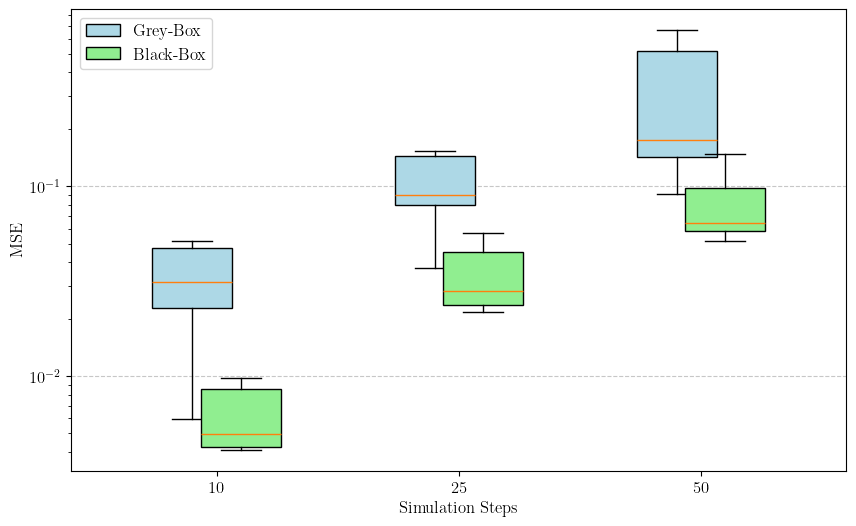

In [47]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    'font.serif' : 'Computer Modern Roman',
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
}
plt.rcParams.update(tex_fonts)

# Daten gruppieren: Jeweils gleiche Größen nebeneinander
data = [
    mse_grey_10_small_v, mse_black_no_eps_10_small_v,
    mse_grey_25_small_v, mse_black_no_eps_25_small_v,
    mse_grey_50_small_v, mse_black_no_eps_50_small_v
]

# data = [
#     mse_grey_10_mid_v, mse_black_no_eps_10_mid_v,
#     mse_grey_25_mid_v, mse_black_no_eps_25_mid_v,
#     mse_grey_50_mid_v, mse_black_no_eps_50_mid_v
# ]

size_labels = [r"10", r"25", r"50"]
positions = [1, 1.2, 2, 2.2, 3, 3.2]  # Leicht versetzte Positionen

# Farben definieren
colors = ["lightblue", "lightgreen"]

# Boxplot erstellen
fig=plt.figure(figsize=(10, 6))
bp = plt.boxplot(data, positions=positions, showfliers=False, patch_artist=True)

# Farben zuweisen
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i % 2])

# Achsenbeschriftung anpassen
plt.xticks([1.1, 2.1, 3.1], size_labels)  # Gemeinsame Labels für gleiche Größen
plt.yscale('log')  # Log-Skalierung zur besseren Darstellung
plt.ylabel(r"MSE")
plt.xlabel(r"Simulation Steps")
#plt.title(r"MSE Boxplot for Grey- and Black-Box Models")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Legende hinzufügen
plt.legend([bp['boxes'][0], bp['boxes'][1]], ["Grey-Box", "Black-Box"], loc="upper left")

# Plot anzeigen

#plt.tight_layout()
fig.show()
plt.savefig('pictures/Sim_comp.pdf', bbox_inches="tight")